In [251]:
# TODO
# change all 'doi:' to 'doi.org/'?
# all the plotting cells with .iloc change to use .isin and name as the resort screws things up
# Add Hodgson doline lake and AP lakes
# Should Carter and others, 2013 citation be changed to Fricker and Scambos, 2009? no, redefined as a lake complex? read carter paper or listen to voice memo
# Should Fricker and others, 2010 citation for Mac7/8 be changed to Carter and others, 2011? (I don't see Mac7/8 in this paper)
# Drop outlines from lakes_gdf that were renamed from Bindschadler_1 and _2 to Mac7 and Mac8; determine which drainage basin they are in

In [252]:
# This notebook collates Antarctic active subglacial lakes from past outline inventories 
# (Smith and others, 2009; Siegfried & Fricker, 2018) as well as point data of lakes in the latest inventory 
# (Livingstone and others, 2022) as well as individual studies since.
#
# Written 2023-01-17 by W. Sauthoff (sauthoff@mines.edu)

In [253]:
# Install package
%pip install openpyxl

Note: you may need to restart the kernel to use updated packages.


In [254]:
# Import packages
import fiona
import geopandas as gpd
import glob
import h5py
import math
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from shapely.geometry import Point, Polygon, MultiPolygon
from shapely.ops import unary_union
import pyproj
from pyproj import CRS, Geod, Transformer

# Magic functions
%matplotlib widget

# Define data and script directories dependent on home environment
if os.getenv('HOME') == '/home/jovyan':
    DATA_DIR = '/home/jovyan/data'
elif os.getenv('HOME') == '/Users/Wilson': 
    DATA_DIR = '/Volumes/ExtremeSSD/data'

# Define utility functions
def ll2ps(lon, lat):
    """
    Transform coordinates from geodetic coordinates (lon, lat)
    to Antarctic Polar Stereograph coordinates (x, y)
    x, y = ll2ps(lon, lat)
    """
    crs_ll = CRS("EPSG:4326")
    crs_xy = CRS("EPSG:3031")
    ll_to_xy = Transformer.from_crs(crs_ll, crs_xy, always_xy = True)
    x, y = ll_to_xy.transform(lon, lat)
    return x, y

def ps2ll(x, y):
    """
    Transform coordinates from Antarctic Polar Stereograph
    to geodetic (lon, lat) coordinates
    
    lon, lat = ps2ll(x, y)
    """
    crs_ll = CRS("EPSG:4326")
    crs_xy = CRS("EPSG:3031")
    xy_to_ll = Transformer.from_crs(crs_xy, crs_ll, always_xy = True)
    lon, lat = xy_to_ll.transform(x, y)
    return lon, lat

def find_intersections(gdf1, gdf2):
    # Create an empty list to store the results
    intersections = []

    # Iterate over each geometry in gdf1
    for index1, geom1 in gdf1.geometry.items():
        # Compare with each geometry in gdf2
        for index2, geom2 in gdf2.geometry.items():
            if geom1.intersects(geom2):
                # If they intersect, add the indices to the list
                intersections.append((index1, index2))
    return intersections

# Create a Geod object for calculating area on the WGS84 ellipsoid
geod = Geod(ellps="WGS84")

# Import datasets

In [255]:
# Import active subglacial lake outlines from Smith and others (2009) (S09)
# As released in Smith and others, 2012 dataset (https://doi.org/10.15784/601439)
fiona.drvsupport.supported_drivers['KML'] = 'rw'
S09_outlines_lonlat = gpd.read_file('input/lake_outlines/Smith2009_lakes/Antarctic_lakes.kml', driver='KML')

# Ensure GeoDataFrame is in EPSG:4326 for geodesic area calculation
if S09_outlines_lonlat.crs != 'EPSG:4326':
    S09_outlines_lonlat = S09_outlines_lonlat.to_crs('EPSG:4326')

# Calculate the geodesic area for each polygon
S09_outlines_lonlat['area (m^2)'] = S09_outlines_lonlat['geometry'].apply(    
    lambda poly: abs(geod.polygon_area_perimeter(
    poly.exterior.coords.xy[0], poly.exterior.coords.xy[1])[0]) if poly is not None and poly.is_valid else None)

# Convert to crs to epsg:3031
S09_outlines = S09_outlines_lonlat.to_crs(3031)

# Delete original geodataframe
del S09_outlines_lonlat

# Display geodataframe
S09_outlines

/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)


,Name,Description,geometry,area (m^2)
0,Bindschadler_1,<table border=1 width='100%' > <tr><td><bf>Cam...,"POLYGON Z ((-792264.327 -691480.857 1.000, -79...",1.943146e+08
1,Bindschadler_2,<table border=1 width='100%' > <tr><td><bf>Cam...,"POLYGON Z ((-842788.063 -708464.240 1.000, -84...",1.072249e+08
2,Bindschadler_3,<table border=1 width='100%' > <tr><td><bf>Cam...,"POLYGON Z ((-874893.221 -654533.044 1.000, -87...",1.404559e+08
3,Bindschadler_4,<table border=1 width='100%' > <tr><td><bf>Cam...,"POLYGON Z ((-828821.778 -584874.415 1.000, -82...",2.816411e+08
4,Bindschadler_5,<table border=1 width='100%' > <tr><td><bf>Cam...,"POLYGON Z ((-858067.460 -573467.564 1.000, -85...",3.923966e+08
...,...,...,...,...
119,Whillans_6,<table border=1 width='100%' > <tr><td><bf>Cam...,"POLYGON Z ((-451544.869 -488823.261 1.000, -45...",7.458477e+07
120,Whillans_7,<table border=1 width='100%' > <tr><td><bf>Cam...,"POLYGON Z ((-543163.376 -500759.165 1.000, -54...",7.696570e+07
121,Whillans_8,<table border=1 width='100%' > <tr><td><bf>Cam...,"POLYGON Z ((-654478.748 -281124.560 1.000, -65...",1.625714e+08
122,Wilkes_1,<table border=1 width='100%' > <tr><td><bf>Cam...,"POLYGON Z ((2214185.180 -666018.604 1.000, 221...",5.880773e+08


In [256]:
# Import active subglacial lake outlines from Siegfried & Fricker (2018) (SF18)
# Original pub: https://doi.org/10.1017/aog.2017.36 
# Code for loading lake outlines available in code bank associated with Siegfried & Fricker (2021), https://doi.org/10.1029/2020GL091089: 
# https://github.com/mrsiegfried/Siegfried2021-GRL/blob/main/data/outlines/load_lakes.ipynb

# import subglacial lake outlines (Siegfried & Fricker, 2018)
h5f = h5py.File('input/lake_outlines/SiegfriedFricker2018_lakes/SiegfriedFricker2018-outlines.h5', 'r')
outline_geometries = [] # store polygons
citations = [] # store citation information

# we're going to calculate geodesic lake area because that is often screwed up
# and occasionally incorrect in the literature
areas = []

# we're going to need to do some coordinate transforms for the geodesic area
# define CRS for Antarcica and make a converter from xy to ll
CRS_LL = "EPSG:4326" # wgs84 in lon,lat
CRS_XY = h5f.attrs.get('proj_crs') # get projection from hdf5 file
XY_TO_LL = Transformer.from_crs(CRS_XY, CRS_LL, always_xy = True) # make coord transformer
geod = CRS(CRS_LL).get_geod() # geod object for calculating geodesic area on defined ellipsoid

# look through each lake and load all of it's info
for lake in h5f.keys():
    outline_x = h5f[lake]['x'][:]
    outline_y = h5f[lake]['y'][:]
    outlines_xy = np.stack((outline_x, outline_y),axis=2).reshape(outline_x.shape[1], 2)

    # A single lake with multiple polygons is NaN broken---need to identify and
    # load as a MultiPolygon. Otherwise it's easy (just load as polygon)
    if np.isnan(outlines_xy)[:,0].sum() == 0:
        geometry = Polygon(outlines_xy)
        lon, lat = XY_TO_LL.transform(outlines_xy[:,0], outlines_xy[:,1])
        this_area = abs(geod.polygon_area_perimeter(lon,lat)[0])
    else:
        this_area = 0
        # break at NaN values and load each as separate polygons
        idx = np.where(np.isnan(outlines_xy[:,0]))[0]

        # grab outline of first lake before getting into the loop
        this_outline = outlines_xy[0:idx[0],:]
        pgons = [Polygon(this_outline)] # put the first polygon in a list
        lon,lat = XY_TO_LL.transform(this_outline[:,0], this_outline[:,1])
        this_area += abs(geod.polygon_area_perimeter(lon,lat)[0])/1e6 # add its area
        for i in np.arange(0,len(idx)):
            if i == len(idx)-1:
                this_outline = outlines_xy[idx[i]+1:,:]
            else:
                this_outline = outlines_xy[idx[i]+1:idx[i+1]]

            pgons.append(Polygon(this_outline))
            lon,lat = XY_TO_LL.transform(this_outline[:,0], this_outline[:,1])
            this_area += abs(geod.polygon_area_perimeter(lon,lat)[0])/1e6
        geometry = MultiPolygon(pgons)

    # append all the results in the right place
    outline_geometries.append(geometry)
    citations.append(h5f[lake].attrs.get('citation')[0].decode('UTF-8'))
    areas.append(this_area)

# make a pandas dataframe with all the necessary info
df = pd.DataFrame(zip(h5f.keys(), outline_geometries, areas, citations),
                  columns=['name', 'geometry', 'area (m^2)', 'cite'])
# convert to geopands geodataframe
SF18_outlines = gpd.GeoDataFrame(df, crs=CRS_XY, geometry=outline_geometries)
# close HDF5 file
h5f.close()

# Display geodataframe
SF18_outlines

,name,geometry,area (m^2),cite
0,Bindschadler_1,"POLYGON ((-792264.327 -691480.857, -791281.458...",1.943146e+08,"Smith and others, 2009, J. Glac., doi:10.3189/..."
1,Bindschadler_2,"POLYGON ((-842788.063 -708464.240, -842354.948...",1.072249e+08,"Smith and others, 2009, J. Glac., doi:10.3189/..."
2,Bindschadler_3,"POLYGON ((-874893.221 -654533.044, -876415.673...",1.404559e+08,"Smith and others, 2009, J. Glac., doi:10.3189/..."
3,Bindschadler_4,"POLYGON ((-828821.778 -584874.415, -828822.032...",2.816411e+08,"Smith and others, 2009, J. Glac., doi:10.3189/..."
4,Bindschadler_5,"POLYGON ((-858067.460 -573467.564, -858714.391...",3.923966e+08,"Smith and others, 2009, J. Glac., doi:10.3189/..."
...,...,...,...,...
126,Whillans_6,"POLYGON ((-451544.869 -488823.261, -451209.964...",7.458477e+07,"Smith and others, 2009, J. Glac., doi:10.3189/..."
127,Whillans_7,"POLYGON ((-543163.376 -500759.165, -542800.367...",7.696570e+07,"Smith and others, 2009, J. Glac., doi:10.3189/..."
128,Whillans_8,"POLYGON ((-654478.748 -281124.560, -653777.327...",1.625714e+08,"Smith and others, 2009, J. Glac., doi:10.3189/..."
129,Wilkes_1,"POLYGON ((2214185.180 -666018.604, 2214317.389...",5.880773e+08,"Smith and others, 2009, J. Glac., doi:10.3189/..."


In [257]:
# Copy SF18_outlines to isolate outlines new in SF18
SF18_outlines_SF18only = SF18_outlines.copy(deep=True)

# Drop rows where 'cite' column equals the specified string
SF18_outlines_SF18only = SF18_outlines_SF18only[~SF18_outlines_SF18only['cite'].eq('Smith and others, 2009, J. Glac., doi:10.3189/002214309789470879')]

In [258]:
SF18_outlines_SF18only

,name,geometry,area (m^2),cite
23,ConwaySubglacialLake,"POLYGON ((-312825.002 -511425.001, -312699.997...",2.669973e+08,"Fricker & Scambos, 2009, J. Glac., doi:10.3189..."
25,Cook_E2,"POLYGON ((765592.392 -1714713.856, 765682.174 ...",2.680933e+08,"McMillan and others, 2013, GRL, doi:10.1002/gr..."
41,EngelhardtSubglacialLake,"POLYGON ((-271824.984 -628674.969, -271699.995...",3.577632e+08,"Fricker & Scambos, 2009, J. Glac., doi:10.3189..."
65,KT1,"POLYGON ((-556189.687 -681400.000, -556000.000...",4.549884e+07,"Kim and others, 2016, TC, doi:10.5194/tc-10-29..."
66,KT2,"POLYGON ((-441794.803 -712600.000, -441600.000...",3.315274e+07,"Kim and others, 2016, TC, doi:10.5194/tc-10-29..."
67,KT3,"POLYGON ((-399646.273 -716600.000, -399600.000...",4.055444e+07,"Kim and others, 2016, TC, doi:10.5194/tc-10-29..."
80,Lake10,"POLYGON ((-227949.981 -569549.997, -228075.000...",2.587121e+07,"Fricker & Scambos, 2009, J. Glac., doi:10.3189..."
81,Lake12,"POLYGON ((-224449.970 -604674.969, -224449.970...",6.689842e+07,"Fricker & Scambos, 2009, J. Glac., doi:10.3189..."
82,Lake78,"MULTIPOLYGON (((-257325.009 -525800.047, -2571...",2.330027e+02,"Carter and others, 2013, J. Glac., doi:10.3189..."
85,Mac1,"POLYGON ((-629350.010 -889125.010, -629325.010...",1.563754e+08,"Fricker and others, 2010, J. Glac., doi:10.318..."


In [259]:
# Read subglacial lake point data from Livingstone and others (2022) (L22), https://doi.org/10.1038/s43017-021-00246-9
url = 'https://static-content.springer.com/esm/art%3A10.1038%2Fs43017-021-00246-9/MediaObjects/43017_2021_246_MOESM1_ESM.xlsx'
use_cols = ['Name', 'Lat.  oN', 'Lon. oE', 'Lake Type', 'References', 'Prior Inventory']
import_rows = np.arange(0,676)
L22_points = pd.read_excel(url, sheet_name='Antarctica', usecols=use_cols, skiprows = lambda x: x not in import_rows)

# View just the active lakes of the pandas dataset
L22_activelake_points = L22_points[L22_points['Lake Type'].str.strip().isin(['Active'])]

# Reset the index, dropping the old one
L22_activelake_points = L22_activelake_points.reset_index(drop=True)

# Display geodataframe
L22_activelake_points

,Name,Lat. oN,Lon. oE,Lake Type,References,Prior Inventory
0,Bindschadler5,-80.610,-123.994,Active,Gray et al. (2005); Smith et al. (2009),Wright & Siegert (2012)
1,Kamb10,-81.446,-120.134,Active,Gray et al. (2005); Smith et al. (2009),Wright & Siegert (2012)
2,L1,-74.000,133.270,Active,Wingham et al. (2006); Surveyed by ICECAP in 2...,Wright & Siegert (2012)
3,U1,-75.940,135.000,Active,Wingham et al. (2006),Wright & Siegert (2012)
4,U2,-76.340,135.770,Active,Wingham et al. (2006),Wright & Siegert (2012)
...,...,...,...,...,...,...
135,THW142,-76.618,-106.185,Active,Smith et al. (2017); Hoffman et al. (2020); Ma...,NaN
136,THW124,-76.462,-106.893,Active,Smith et al. (2017) and Hoffman et al. (2020).,NaN
137,THW70,-75.990,-107.023,Active,Smith et al. (2017) and Hoffman et al. (2020).,NaN
138,WT,-77.300,-114.000,Active,Hoffman et al. (2020).,NaN


In [260]:
# Isolate lakes not previously included in Smith and others (2009; 2017) or Siegfried and Fricker (2018)
L22_activelake_points_new = L22_activelake_points.copy(deep=True)
L22_activelake_points_new.drop(L22_activelake_points_new.loc[L22_activelake_points['References'].str.contains('Smith et al.|Siegfried & Fricker')].index, inplace=True)
L22_activelake_points_new = L22_activelake_points_new.reset_index(drop=True)
# print(len(L22_activelake_points_new))
L22_activelake_points_new

,Name,Lat. oN,Lon. oE,Lake Type,References,Prior Inventory
0,L1,-74.000,133.270,Active,Wingham et al. (2006); Surveyed by ICECAP in 2...,Wright & Siegert (2012)
1,U1,-75.940,135.000,Active,Wingham et al. (2006),Wright & Siegert (2012)
2,U2,-76.340,135.770,Active,Wingham et al. (2006),Wright & Siegert (2012)
3,U3,-76.680,135.930,Active,Wingham et al. (2006),Wright & Siegert (2012)
4,Byrd1 (DL),-81.026,148.302,Active,"Stearns et al., (2008)",Wright & Siegert (2012)
5,Byrd2 (UL),-80.684,146.887,Active,"Stearns et al., (2008)",Wright & Siegert (2012)
6,“Site A”,-67.800,112.540,Active,N. Young (personal comm.),Wright & Siegert (2012)
7,“Site B”,-67.870,113.530,Active,N. Young (personal comm.),Wright & Siegert (2012)
8,“Site C”,-67.840,114.040,Active,N. Young (personal comm.),Wright & Siegert (2012)
9,Crane Glacier,-65.358,-62.458,Active,Scambos et al. (2011).,NaN


In [261]:
# Copy SF18 outline inventory to add entries from more recent publications
lakes_gdf = SF18_outlines.copy(deep=True)

In [262]:
# Examine citations column
lakes_gdf['cite'].unique()

array(['Smith and others, 2009, J. Glac., doi:10.3189/002214309789470879',
       'Fricker & Scambos, 2009, J. Glac., doi:10.3189/002214309788608813',
       'McMillan and others, 2013, GRL, doi:10.1002/grl.50689',
       'Kim and others, 2016, TC, doi:10.5194/tc-10-2971-2016',
       'Carter and others, 2013, J. Glac., doi:10.3189/2013JoG13J085',
       'Fricker and others, 2010, J. Glac., doi:10.3189/002214310791968557',
       'Fricker and others, 2014, J. Glac., doi:10.3189/2014JoG14J063',
       'Siegfried & Fricker, 2018, Ann. Glac., doi:10.1017/aog.2017.36',
       'Smith and others, 2017, TC, doi:10.5194/tc-11-451-2017'],
      dtype=object)

In [263]:
# Change journal abbreviations to ISO4 standard
# Replace TC with Cryosphere
lakes_gdf = lakes_gdf.replace('Kim and others, 2016, TC, doi:10.5194/tc-10-2971-2016', 'Kim and others, 2016, Cryosphere, doi:10.5194/tc-10-2971-2016')
lakes_gdf = lakes_gdf.replace('Smith and others, 2017, TC, doi:10.5194/tc-11-451-2017', 'Smith and others, 2017, Cryosphere, doi:10.5194/tc-11-451-2017')
# Replace GRL with Geophys. Res. Lett.
lakes_gdf = lakes_gdf.replace('McMillan and others, 2013, GRL, doi:10.1002/grl.50689', 'McMillan and others, 2013, Geophys. Res. Lett., doi:10.1002/grl.50689')
# Ensure replacements worked as expected
lakes_gdf['cite'].unique()

array(['Smith and others, 2009, J. Glac., doi:10.3189/002214309789470879',
       'Fricker & Scambos, 2009, J. Glac., doi:10.3189/002214309788608813',
       'McMillan and others, 2013, Geophys. Res. Lett., doi:10.1002/grl.50689',
       'Kim and others, 2016, Cryosphere, doi:10.5194/tc-10-2971-2016',
       'Carter and others, 2013, J. Glac., doi:10.3189/2013JoG13J085',
       'Fricker and others, 2010, J. Glac., doi:10.3189/002214310791968557',
       'Fricker and others, 2014, J. Glac., doi:10.3189/2014JoG14J063',
       'Siegfried & Fricker, 2018, Ann. Glac., doi:10.1017/aog.2017.36',
       'Smith and others, 2017, Cryosphere, doi:10.5194/tc-11-451-2017'],
      dtype=object)

In [264]:
# Find area of previously identified lakes inventoried in SF18
# to use as guesstimate for lakes without this information or figures 
# allowing for closer guesstimate
print('mean lake area: ', np.round(np.mean(SF18_outlines['area (m^2)'])/1e6, 1), ' km^2')

mean lake area:  202.2  km^2


In [265]:
# Add entries for newer lakes from publications not included in SF18 inventory 
# Used approximated centroid point when lake outline was unavailable

# Smith 2009 Recovery_8 was argued to not be an active subglacial lake in Fricker and others (2010),
# so not included Siegfried & Fricker (2018) outlines; including here to determine if there's been activity since
lake_gdf = S09_outlines[S09_outlines['Name'] == 'Recovery_8']
name = lake_gdf['Name'].values[0]
# S09 outline inventory uses 3D polygons with z dimension vs. 2D polygons in SF18 inventory
# Extract the point values that define the perimeter of the polygon to make polygon without third z dimension
# Extract 2D coordinates (X, Y) from the 3D polygon (X, Y, Z)
xy_coords = [(x, y) for x, y, z in lake_gdf.geometry.values[0].exterior.coords]
# Create a new 2D polygon from these coordinates
lake_poly_2d = Polygon(xy_coords)
geometry = lake_poly_2d
# Store area that was previously calculated to be geodesic area
area = lake_gdf['area (m^2)'].values[0]
# Store citation info from another lake from the same S09 study in the SF18 citation format
cite = SF18_outlines[SF18_outlines['name'] == 'Bindschadler_1'].cite.values[0]
# Make entry into pandas dataframe to concatenate to inventory
gdf = gpd.GeoDataFrame([[name, geometry, area, cite]], columns=lakes_gdf.columns)
# Set CRS
gdf.crs = lakes_gdf.crs
# Ensure that new entry isn't already in inventory before adding
gdf_diff = gdf[~gdf['name'].isin(lakes_gdf['name'])]
# gdf_diff = gdf[~gdf['name'].isin(lakes_gdf['name'])]
# Add entry to inventory
lakes_gdf = pd.concat([lakes_gdf, gdf_diff], ignore_index=True)

In [266]:
# Livingstone and others, 2022 active lakes points (no outlines available):
# Wingham and others, 2006 (within Livingstone and others, 2022 inventory)
# Lakes L1, U1, U2, U3
areas = [600e6, 200e6, 200e6, 400e6]  # Lake L1 area estimated in paper, but U1-3 were guestimated from their Fig. 1
for i in range(0, 4):
    name = L22_activelake_points_new.iloc[i]['Name']
    lon = L22_activelake_points_new.iloc[i]['Lon. oE']
    lat = L22_activelake_points_new.iloc[i]['Lat.  oN']
    geometry = Point(ll2ps(lon, lat)).buffer(math.sqrt(areas[i] / math.pi))
    area = areas[i]
    cite = 'Wingham and others, 2006, Nature, doi:10.1038/nature04660'
    # Make entry into GeoDataFrame to concatenate to inventory
    gdf = gpd.GeoDataFrame([[name, geometry, area, cite]], columns=lakes_gdf.columns, geometry=[geometry], crs=lakes_gdf.crs)
    # Set CRS
    gdf.crs = lakes_gdf.crs
    # Ensure that new entry isn't already in inventory before adding
    gdf_diff = gdf[~gdf['name'].isin(lakes_gdf['name'])]
    # Add entry to inventory
    lakes_gdf = gpd.GeoDataFrame(pd.concat([lakes_gdf, gdf_diff], ignore_index=True), crs=lakes_gdf.crs)

# Byrd1 (DL) Byrd1 (DL) were included in Smith and others, 2009 and thus Siegfried & Fricker, 2018 inventories
   
# N. Young personal comm. (within Wright & Siegert, 2012 and Livingstone and others, 2022 inventories)
# Lakes Site A, Site B, Site C
area = 200e6
for i in range(6, 9):
    name = L22_activelake_points_new.iloc[i]['Name'].strip('“”')  # Strip curly double quotation marks from names
    lon = L22_activelake_points_new.iloc[i]['Lon. oE']
    lat = L22_activelake_points_new.iloc[i]['Lat.  oN']
    geometry = Point(ll2ps(lon, lat)).buffer(math.sqrt(area / math.pi))
    cite = 'Wright & Siegert, 2012, Antarct. Sci., doi:10.1017/S095410201200048X'
    gdf = gpd.GeoDataFrame([[name, geometry, area, cite]], columns=lakes_gdf.columns)
    gdf.crs = lakes_gdf.crs
    gdf_diff = gdf[~gdf['name'].isin(lakes_gdf['name'])]
    lakes_gdf = pd.concat([lakes_gdf, gdf_diff], ignore_index=True)

# # Scambos and others, 2011 (within Livingstone and others, 2022 inventory)
# # Crane Glacier lake
# area = 4.5e6
# for i in range(9, 10):
#     name = L22_activelake_points_new.iloc[i]['Name'].split()[0]  # Only use first word to avoid spaces
#     lon = L22_activelake_points_new.iloc[i]['Lon. oE']
#     lat = L22_activelake_points_new.iloc[i]['Lat.  oN']
#     geometry = Point(ll2ps(lon, lat)).buffer(math.sqrt(area / math.pi))
#     cite = 'Scambos and others, 2011, Ann. Glaciol., doi:10.3189/172756411799096204'
#     gdf = gpd.GeoDataFrame([[name, geometry, area, cite]], columns=lakes_gdf.columns)
#     gdf.crs = lakes_gdf.crs
#     gdf_diff = gdf[~gdf['name'].isin(lakes_gdf['name'])]
#     lakes_gdf = pd.concat([lakes_gdf, gdf_diff], ignore_index=True)
# Lacked sufficient data density in data_counts of altimetry datasets to use

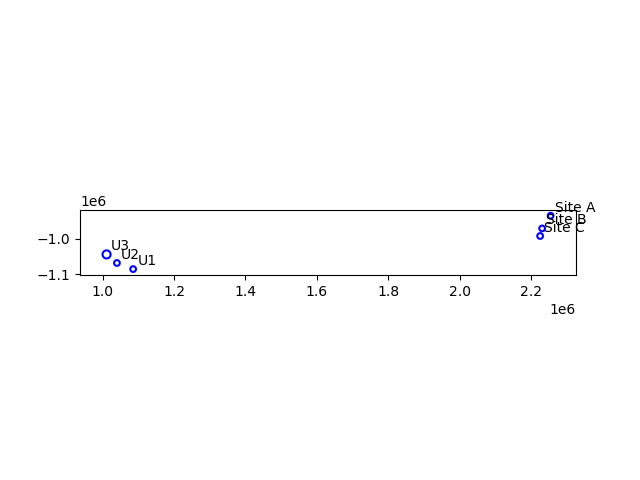

In [267]:
fig, ax = plt.subplots()

# Filter rows on the 'name' column
filtered_gdf = lakes_gdf[lakes_gdf['name'].isin(['Site A', 'Site B', 'Site C', 'U1', 'U2', 'U3'])]

filtered_gdf.boundary.plot(ax=ax, color='blue')
# Iterate through the GeoDataFrame to annotate each polygon.
for idx, row in filtered_gdf.iterrows():
    # Use the centroid of each polygon for the annotation location.
    centroid = row['geometry'].centroid
    ax.annotate(text=row['name'], xy=(centroid.x, centroid.y), xytext=(3, 3), textcoords="offset points")
plt.show()

In [268]:
# Hoffman and others, 2020 redelineations of two Thwaites lakes
# Obtained lake outlines from author Hoffman

# Read lake outline geojsons into geodataframes
file_path = 'input/lake_outlines/Hoffman2020_subglacial_lakes/Thw124.geojson'
Hoffman2020_Thw124 = gpd.read_file(file_path)

file_path = 'input/lake_outlines/Hoffman2020_subglacial_lakes/Thw142.geojson'
Hoffman2020_Thw142 = gpd.read_file(file_path)

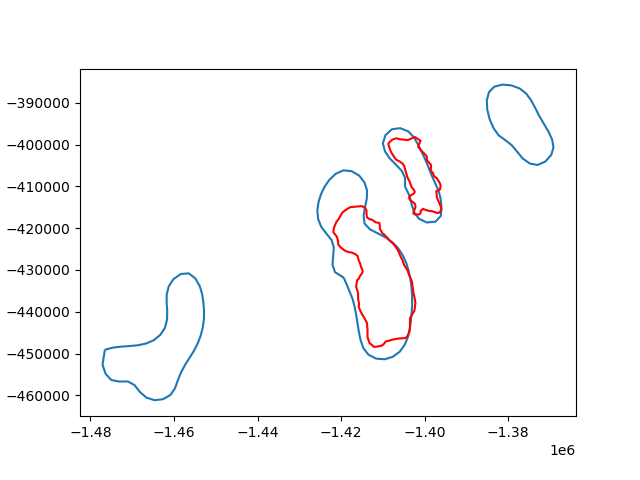

In [269]:
fig, ax = plt.subplots()

lakes_gdf[lakes_gdf['name'].isin(['Thw_70', 'Thw_124', 'Thw_142', 'Thw_170'])].boundary.plot(ax=ax)
Hoffman2020_Thw124.boundary.plot(ax=ax, color='red')
Hoffman2020_Thw142.boundary.plot(ax=ax, color='red')
plt.show()

In [270]:
# Hoffman and others redelineated Thw124 and Thw142; however outlines are largely similar to Smith and others, 2017 
# delineations and outlines were not publicly available at time of investigation, so we use the Smith others, 2017
# delineations contained in SF18 inventory

In [271]:
# Hoffman and others, 2020 (within Livingstone and others, 2022 inventory as lake points)

# Takahe lakes (TL; named after nearby Mt. Takahe) on Haynes Glacier
# detailed in Hoffman and others, 2020 supplement
# & Western Thwaites (WT) lake

# https://tc.copernicus.org/articles/14/4603/2020/tc-14-4603-2020-supplement.pdf

# Make list of lake names
lake_names = ['TL96', 'TL108', 'TL115', 'TL122', 'WT']

for lake_name in lake_names:
    # Load geojson into geodataframe
    lake_geojson_path = f'input/lake_outlines/Hoffman2020_subglacial_lakes/{lake_name}.geojson'
    lake_gdf = gpd.read_file(lake_geojson_path)

    # Extract name and geometry
    name = lake_gdf['id'].values[0]
    geometry = lake_gdf['geometry'].iloc[0]
    
    # Convert CRS to 4326 for geodesic area calculations
    lake_gdf = lake_gdf.to_crs('EPSG:4326')
    area = lake_gdf['geometry'].apply(lambda poly: abs(geod.polygon_area_perimeter(poly.exterior.coords.xy[0], poly.exterior.coords.xy[1])[0]) if poly is not None and poly.is_valid else None)[0]
    
    # Convert CRS back to 3031 for plotting
    lake_gdf = lake_gdf.to_crs('EPSG:3031')
    cite = 'Hoffman and others, 2020, Cryosphere, doi:10.5194/tc-14-4603-2020'
    
    # Create a GeoDataFrame for the current lake and append it if it's not already present
    gdf = gpd.GeoDataFrame([[name, geometry, area, cite]], columns=lakes_gdf.columns)
    gdf.crs = lakes_gdf.crs
    gdf_diff = gdf[~gdf['name'].isin(lakes_gdf['name'])]
    lakes_gdf = pd.concat([lakes_gdf, gdf_diff], ignore_index=True)

/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype

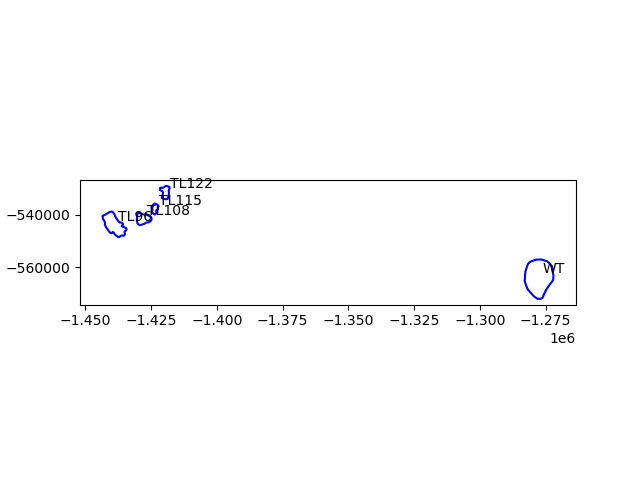

In [272]:
fig, ax = plt.subplots()

# Filter rows on the 'name' column
filtered_gdf = lakes_gdf[lakes_gdf['name'].isin(lake_names)]

filtered_gdf.boundary.plot(ax=ax, color='blue')
# Iterate through the GeoDataFrame to annotate each polygon.
for idx, row in filtered_gdf.iterrows():
    # Use the centroid of each polygon for the annotation location.
    centroid = row['geometry'].centroid
    ax.annotate(text=row['name'], xy=(centroid.x, centroid.y), xytext=(3, 3), textcoords="offset points")
plt.show()

In [273]:
# Neckel and others, 2020 (publication not included in Livingstone and others, 2022 inventory)
# on active subglacial lakes on Jutulstraumen Glacier
# https://doi.org/10.1594/PANGAEA.927120

# Read shape file into geodataframe
file_path = 'input/lake_outlines/Neckel2021_Jutulstraumen_lakes/JG_interferometry_lake_outlines.shp'
Neckel2020_outlines = gpd.read_file(file_path)

# Display geodataframe
Neckel2020_outlines

,Date,Year,Month,Movement,Feature,Lon,Lat,geometry
0,2017_1112_1124_1206_01,2017,11,uplift,D2_b,1.4390,-73.1821,"POLYGON ((46000.258 1842014.397, 46455.043 184..."
1,2017_1112_1124_1206_02,2017,11,subsidence,D1_b,1.8943,-73.1438,"POLYGON ((61125.377 1845053.779, 61359.548 184..."
2,2017_1112_1124_1206_03,2017,11,subsidence,D1_a,2.0457,-73.1429,"POLYGON ((67375.406 1843965.043, 67844.790 184..."
3,2017_1206_1218_1230_01,2017,12,uplift,E2,1.3370,-73.3150,"POLYGON ((44021.847 1830735.929, 44222.857 183..."
4,2017_1206_1218_1230_02,2017,12,subsidence,E1,1.4330,-73.1930,"POLYGON ((44944.224 1841622.897, 45377.363 184..."
5,2020_0101_0113_0125_01,2020,1,uplift,F2,1.3450,-73.3220,"POLYGON ((40570.497 1825983.767, 41135.159 182..."
6,2020_0101_0113_0125_02,2020,1,subsidence,F1,2.0880,-73.3380,"POLYGON ((66809.882 1824720.853, 67159.086 182..."
7,2017_1112_1124_1206_01,2017,11,uplift,D2_a,1.7700,-73.1259,"POLYGON ((56114.824 1846982.083, 56646.246 184..."


In [274]:
# Drop columns unnecessary to our analysis
Neckel2020_outlines.drop(columns=['Date', 'Year', 'Month', 'Movement', 'Lon', 'Lat'], inplace=True)

# Rename 'Feature' col to 'Name' to match lakes_gdf
Neckel2020_outlines = Neckel2020_outlines.rename(columns={'Feature': 'name'})

# Display geodataframe
Neckel2020_outlines

,name,geometry
0,D2_b,"POLYGON ((46000.258 1842014.397, 46455.043 184..."
1,D1_b,"POLYGON ((61125.377 1845053.779, 61359.548 184..."
2,D1_a,"POLYGON ((67375.406 1843965.043, 67844.790 184..."
3,E2,"POLYGON ((44021.847 1830735.929, 44222.857 183..."
4,E1,"POLYGON ((44944.224 1841622.897, 45377.363 184..."
5,F2,"POLYGON ((40570.497 1825983.767, 41135.159 182..."
6,F1,"POLYGON ((66809.882 1824720.853, 67159.086 182..."
7,D2_a,"POLYGON ((56114.824 1846982.083, 56646.246 184..."


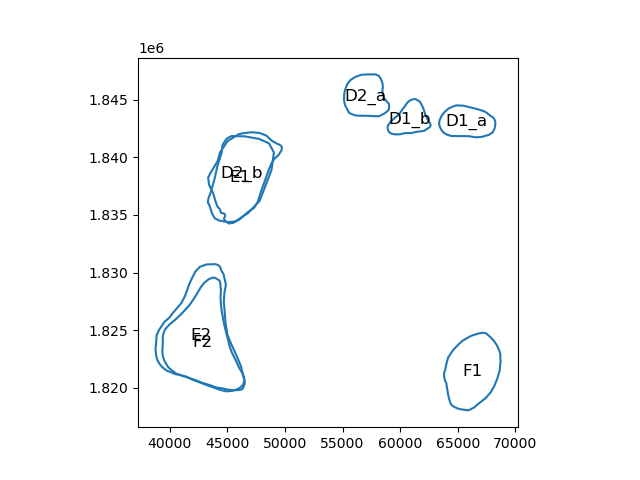

In [275]:
fig, ax = plt.subplots()

Neckel2020_outlines.boundary.plot(ax=ax)

# Adding labels to the center of each polygon
for idx, row in Neckel2020_outlines.iterrows():
    centroid = row.geometry.centroid
    ax.text(centroid.x, centroid.y, row['name'], fontsize=12, ha='center', va='center')

In [276]:
# This is the only set of previously identified lakes that has spatiotemporally evolving outlines
# For simplicity, we collapse this spatiotemporal into a static outline that is the unary union of all outlines of each lake

# Define the two sets of criteria
criterias = [['D2_b', 'E1'], ['E2', 'F2']]

for criteria in criterias:
    # Filter rows where 'Feature' matches the current set of criteria
    rows_to_combine = Neckel2020_outlines[Neckel2020_outlines['name'].isin(criteria)]

    # Check if we have at least two polygons to combine for the current criteria
    if len(rows_to_combine) >= 2:
        # Perform the union of the polygons
        combined_polygon = rows_to_combine['geometry'].unary_union

        # Create a new row with the combined geometry and any other necessary attributes
        new_row_data = {
            'geometry': combined_polygon,
            'name': 'Combined_' + '_'.join(criteria),  # Example of setting the Feature column
            # Set other attributes as needed
        }
        new_row = gpd.GeoDataFrame([new_row_data], crs=gdf.crs)

        # Use pandas.concat instead of append
        Neckel2020_outlines = pd.concat([Neckel2020_outlines, new_row], ignore_index=True)

    # Ensure you reference the correct GeoDataFrame when removing rows
    Neckel2020_outlines = Neckel2020_outlines[~Neckel2020_outlines['name'].isin(criteria)]

# Add citation column
Neckel2020_outlines['cite'] = 'Neckel and others, 2021, Geophys. Res. Lett., doi:10.1029/2021GL094472'

# Reset the index of the GeoDataFrame after all operations
Neckel2020_outlines = Neckel2020_outlines.reset_index(drop=True)

# Ensure GeoDataFrame is in EPSG:4326 for geodesic area calculation
if Neckel2020_outlines.crs != 'EPSG:4326':
    Neckel2020_outlines = Neckel2020_outlines.to_crs("EPSG:4326")
    
# Calculate the geodesic area for each polygon
Neckel2020_outlines['area (m^2)'] = Neckel2020_outlines.geometry.apply(
    lambda poly: abs(geod.polygon_area_perimeter(
        poly.exterior.coords.xy[0], poly.exterior.coords.xy[1])[0]) if poly is not None and poly.is_valid else None)

# Convert to crs to epsg:3031
Neckel2020_outlines = Neckel2020_outlines.to_crs(3031)

# Add a prefix to all the names to indicate their locations on Jutulstraumen Glacier
Neckel2020_outlines['name'] = 'JG_' + Neckel2020_outlines['name']

# Add to lakes_gdf
gdf_diff = Neckel2020_outlines[~Neckel2020_outlines['name'].isin(lakes_gdf['name'])]
lakes_gdf = pd.concat([lakes_gdf, gdf_diff], ignore_index=True)

/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)


In [277]:
Neckel2020_outlines

,name,geometry,cite,area (m^2)
0,JG_D1_b,"POLYGON ((61125.377 1845053.779, 61359.548 184...","Neckel and others, 2021, Geophys. Res. Lett., ...",7.190591e+06
1,JG_D1_a,"POLYGON ((67375.406 1843965.043, 67844.790 184...","Neckel and others, 2021, Geophys. Res. Lett., ...",1.068865e+07
2,JG_F1,"POLYGON ((66809.882 1824720.853, 67159.086 182...","Neckel and others, 2021, Geophys. Res. Lett., ...",2.447534e+07
3,JG_D2_a,"POLYGON ((56114.824 1846982.083, 56646.246 184...","Neckel and others, 2021, Geophys. Res. Lett., ...",1.145730e+07
4,JG_Combined_D2_b_E1,"POLYGON ((45377.363 1841850.477, 45723.017 184...","Neckel and others, 2021, Geophys. Res. Lett., ...",3.391586e+07
5,JG_Combined_E2_F2,"POLYGON ((46521.167 1820579.145, 46508.756 182...","Neckel and others, 2021, Geophys. Res. Lett., ...",5.225521e+07


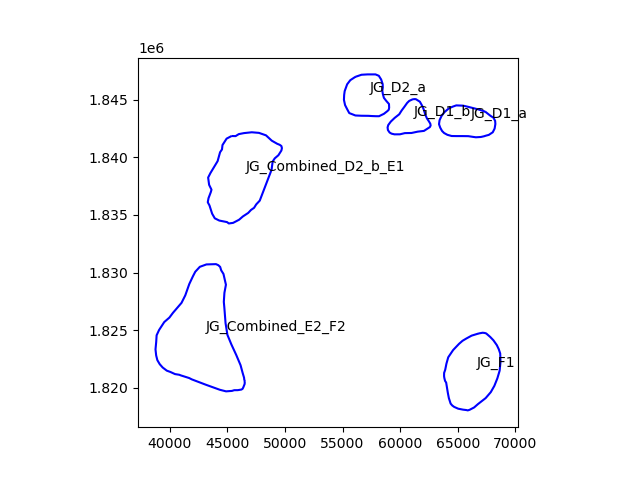

In [278]:
fig, ax = plt.subplots()

# Filter rows on the 'name' column
filtered_gdf = lakes_gdf[lakes_gdf['name'].isin(Neckel2020_outlines['name'].tolist())]

filtered_gdf.boundary.plot(ax=ax, color='blue')
# Iterate through the GeoDataFrame to annotate each polygon.
for idx, row in filtered_gdf.iterrows():
    # Use the centroid of each polygon for the annotation location.
    centroid = row['geometry'].centroid
    ax.annotate(text=row['name'], xy=(centroid.x, centroid.y), xytext=(3, 3), textcoords="offset points")
plt.show()

In [279]:
# Siegfried and Fricker, 2021 (publication not included in Livingstone and others, 2022 inventory)
# These are discussed but no figures contain outlines; Siegfried confirmed no outlines were generated
# Guestimated centroid point and approximate area

# Lower Subglacial Lake Mercer (LSLM)
name = 'LowerMercerSubglacialLake'
area = 10e6
geometry = Point(-308000, -509000).buffer(math.sqrt(area / math.pi))
cite = 'Siegfried and Fricker, 2021, Geophys. Res. Lett., doi:10.1029/2020GL091089'
gdf = gpd.GeoDataFrame([[name, geometry, area, cite]], columns=lakes_gdf.columns, geometry=[geometry])
gdf.crs = lakes_gdf.crs
gdf_diff = gdf[~gdf['name'].isin(lakes_gdf['name'])]
lakes_gdf = gpd.GeoDataFrame(pd.concat([lakes_gdf, gdf_diff], ignore_index=True), crs=lakes_gdf.crs)

# Lower Subglacial Lake Conway (LSLC)
name = 'LowerSubglacialLakeConway'
area = 10e6
geometry = Point(-282000, -502000).buffer(math.sqrt(area / math.pi))
cite = 'Siegfried and Fricker, 2021, Geophys. Res. Lett., doi:10.1029/2020GL091089'
gdf = gpd.GeoDataFrame([[name, geometry, area, cite]], columns=lakes_gdf.columns, geometry=[geometry])
gdf.crs = lakes_gdf.crs
gdf_diff = gdf[~gdf['name'].isin(lakes_gdf['name'])]
lakes_gdf = gpd.GeoDataFrame(pd.concat([lakes_gdf, gdf_diff], ignore_index=True), crs=lakes_gdf.crs)

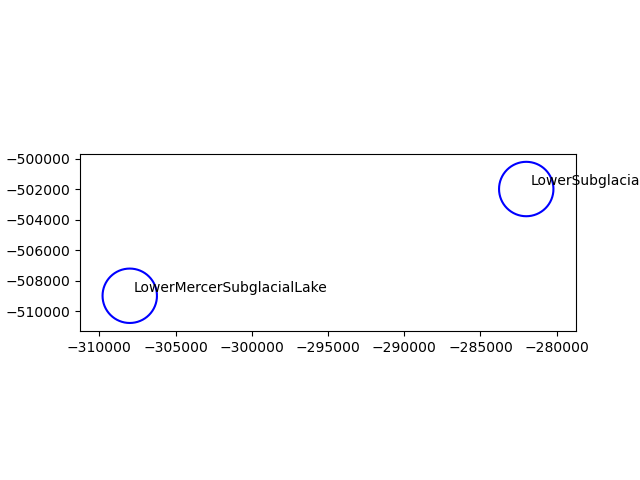

In [280]:
fig, ax = plt.subplots()

# Filter rows on the 'name' column
filtered_gdf = lakes_gdf[lakes_gdf['name'].isin(['LowerMercerSubglacialLake', 'LowerSubglacialLakeConway'])]

filtered_gdf.boundary.plot(ax=ax, color='blue')
# Iterate through the GeoDataFrame to annotate each polygon.
for idx, row in filtered_gdf.iterrows():
    # Use the centroid of each polygon for the annotation location.
    centroid = row['geometry'].centroid
    ax.annotate(text=row['name'], xy=(centroid.x, centroid.y), xytext=(3, 3), textcoords="offset points")
plt.show()

In [281]:
# Hodgson and others, 2022 (publication not included in Livingstone and others, 2022 inventory)
# No figures in publication contain outlines; emailed corresponding author to check

# Coordinates in degrees, minutes, seconds
latitude_dms = (71, 51, 1)
longitude_dms = (68, 28, 36)

# Convert DMS to decimal degrees
def dms_to_decimal(degrees, minutes, seconds):
    return degrees + (minutes / 60) + (seconds / 3600)

latitude_decimal = dms_to_decimal(*latitude_dms)
longitude_decimal = dms_to_decimal(*longitude_dms)

# Considering the direction (S and W are negative)
latitude_decimal = -latitude_decimal
longitude_decimal = -longitude_decimal

# # Mars Glacier lake
# name = 'Mars'
# area = 0.067e6  # Unclear if this is planar or geodesic area
# lon = latitude_decimal
# lat = longitude_decimal
# geometry = Point(ll2ps(lon, lat)).buffer(math.sqrt(area / math.pi))
# cite = 'Hodgson and others, 2022, Cryosphere, doi:10.5194/tc-16-4797-2022'
# gdf = gpd.GeoDataFrame([[name, geometry, area, cite]], columns=lakes_gdf.columns, geometry=[geometry])
# gdf.crs = lakes_gdf.crs
# gdf_diff = gdf[~gdf['name'].isin(lakes_gdf['name'])]
# lakes_gdf = gpd.GeoDataFrame(pd.concat([lakes_gdf, gdf_diff], ignore_index=True), crs=lakes_gdf.crs)
# Area of lake too small to be compatiable with 1-km spatial resolution datasets

# Other doline-style lakes that could be investigated with higher resolution data when it's avialablie at listed in publication

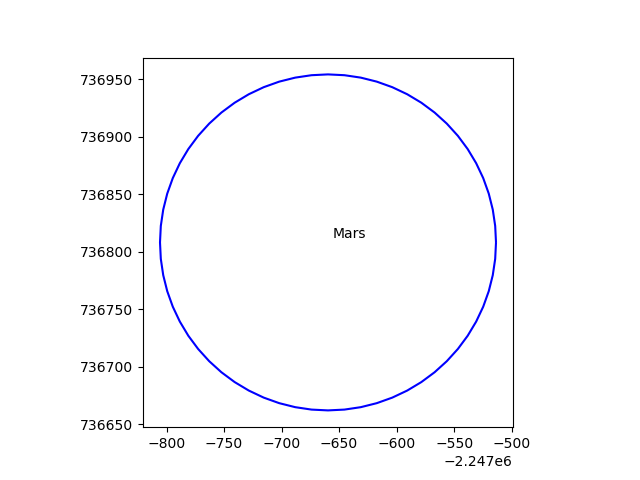

In [282]:
fig, ax = plt.subplots()

# Filter rows on the 'name' column
filtered_gdf = lakes_gdf[lakes_gdf['name'].isin(['Mars'])]

filtered_gdf.boundary.plot(ax=ax, color='blue')
# Iterate through the GeoDataFrame to annotate each polygon.
for idx, row in filtered_gdf.iterrows():
    # Use the centroid of each polygon for the annotation location.
    centroid = row['geometry'].centroid
    ax.annotate(text=row['name'], xy=(centroid.x, centroid.y), xytext=(3, 3), textcoords="offset points")
plt.show()

In [283]:
# Find invalid geometries
invalid_rows = lakes_gdf[~lakes_gdf.is_valid]

# Display the invalid rows
print(invalid_rows)

        name                                           geometry    area (m^2)  \
25   Cook_E2  POLYGON ((765592.392 -1714713.856, 765682.174 ...  2.680933e+08   
85      Mac1  POLYGON ((-629350.010 -889125.010, -629325.010...  1.563754e+08   
86      Mac2  POLYGON ((-657250.020 -890550.040, -657249.980...  1.457161e+08   
87      Mac3  POLYGON ((-642325.010 -883925.000, -642449.980...  1.502500e+08   
88      Mac4  POLYGON ((-739324.970 -857799.960, -739199.980...  7.520909e+07   
89      Mac5  POLYGON ((-734575.010 -842800.020, -734449.990...  5.998647e+07   
103     Rec2  POLYGON ((-389950.015 915200.035, -389824.971 ...  7.096422e+08   
105     Rec4  POLYGON ((-174200.004 944325.029, -174200.000 ...  2.299425e+08   
106     Rec5  POLYGON ((-128199.995 941949.982, -128200.002 ...  2.849787e+08   

                                                  cite  
25   McMillan and others, 2013, Geophys. Res. Lett....  
85   Fricker and others, 2010, J. Glac., doi:10.318...  
86   Fricker and o

In [284]:
# Repair invalid geometries
lakes_gdf.loc[~lakes_gdf.is_valid, 'geometry'] = lakes_gdf[~lakes_gdf.is_valid].geometry.buffer(0)

# Check if there are still any invalid geometries
print(lakes_gdf[~lakes_gdf.is_valid])

Empty GeoDataFrame
Columns: [name, geometry, area (m^2), cite]
Index: []


In [285]:
# Drop Mac7 and Mac8 outlines from lakes_gdf that were renamed from Bindschadler_1 and _2
# These two lakes were renamed in Carter and others, 2011 (https://doi.org/10.3189/002214311798843421) to Mac7 and Mac8
# supposedly under the assumption that these two lakes are within the subglacial watershed of MacAyeal ice stream, however, 
# the renaming was not documented in that paper and so these lake outlines were duplicative to Bindschadler_1 and _2 in the 
# SF18 inventory. Watershed delineation indicates that one of these lakes in the MacAyeal subglacial watershed; however,
# we feel this renaming is unnecessary and confusing, so we opt to use the original names for these two lakes
# (Bindschadler_1 and _2).
lakes_gdf = lakes_gdf[~lakes_gdf['name'].isin(['Mac7', 'Mac8'])]

In [286]:
# Drop outlines from lakes_gdf that are part of SF18_outlines (indexes 0:130)
# and Recovery_8 (idx 131) originally from S09_outlines
lakes_gdf_postSF18 = lakes_gdf.copy(deep=True)
# Drop lakes included in SF18 inventory
lakes_gdf_postSF18.drop(lakes_gdf_postSF18.iloc[0:132].index, inplace=True)

In [287]:
# Import CryoSat-2 SARIn mode mask
# See 0_preprocess_data.ipynb for data source and pre-processing steps
gdf_SARIn_3_1 = gpd.read_file('output/CS2_SARIn_mode_masks/gdf_SARIn_3_1.geojson')
gdf_SARIn_3_1_3_6_diff= gpd.read_file('output/CS2_SARIn_mode_masks/gdf_SARIn_3_1_3_6_diff.geojson')

In [288]:
# Create a column to indicate the time period each lake has CS2 SARIn coverage if any

# Combining the SARIn mode masks the occur during the CS2-IS2 analysis time period (2010-2023)
combined_geom = unary_union([gdf_SARIn_3_1, gdf_SARIn_3_1_3_6_diff])

# Creating a new GeoDataFrame with the combined geometry
gdf_SARIn_3_1_3_6 = gpd.GeoDataFrame(geometry=[combined_geom])
gdf_SARIn_3_1_3_6.crs = 'epsg:3031'

# Use the 'within' method to find lakes that have CS2 SARIn coverage during the different SARIn mode mask version
# Using an inland buffer to capture edge cases Byrd_s1, Foundation_2, and Mac3 that has CS2 SARIn but not fully within the mode mask
# See 0_preprocess_data.ipynb for more info
CS2_SARIn_3_1_col = lakes_gdf.geometry.within(gdf_SARIn_3_1.buffer(15e3).geometry.iloc[0])
CS2_SARIn_3_1_3_6_col = lakes_gdf.geometry.within(gdf_SARIn_3_1_3_6.buffer(15e3).geometry.iloc[0])

# Conditions
condition1 = (CS2_SARIn_3_1_col == True) & (CS2_SARIn_3_1_3_6_col == True)  # Both True
condition2 = (CS2_SARIn_3_1_col == False) & (CS2_SARIn_3_1_3_6_col == True) # Only CS2_SARIn_3_1_col is True

# Choices based on the conditions
choices = ['2010.5-2018.75', '2013.75-2018.75']

# Use np.select to apply conditions and choices
lakes_gdf['CS2_SARIn_time_period'] = np.select([condition1, condition2], choices, default=np.nan)

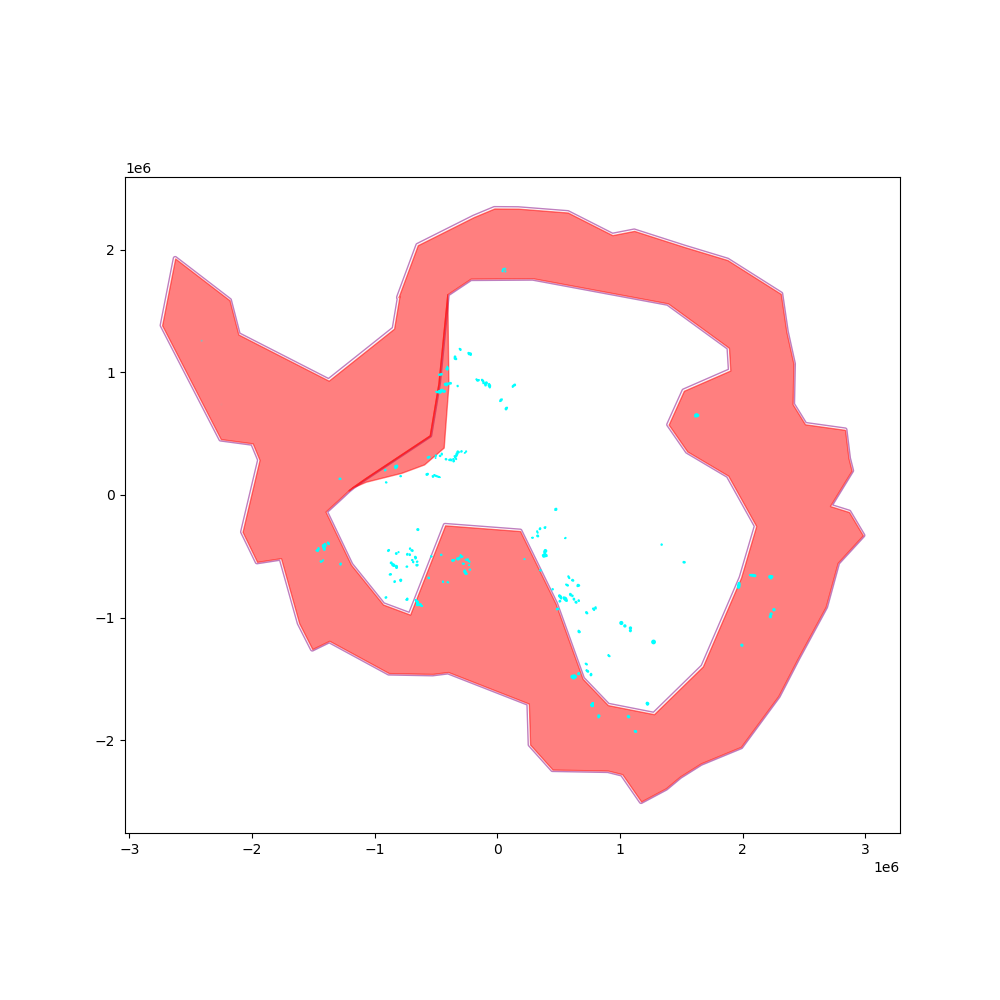

In [289]:
# Plot lakes_gdf with CS2 SARIn mode mask
fig, ax = plt.subplots(figsize=(10,10))
gdf_SARIn_3_1.plot(ax=ax, edgecolor='red', facecolor='red', label='SARIn mode mask 3.1', alpha=0.5)
gdf_SARIn_3_1.buffer(15e3).plot(ax=ax, edgecolor='purple', facecolor='none', label='SARIn mode mask 3.1 - 5 km inland buffer', alpha=0.5)
gdf_SARIn_3_1_3_6_diff.plot(ax=ax, edgecolor='red', facecolor='red', label='SARIn mode mask 3.6', alpha=0.5)
lakes_gdf.plot(ax=ax, edgecolor='cyan', facecolor='cyan')
plt.show()

In [290]:
# Sort the GeoDataFrame by the 'name' column
lakes_gdf = lakes_gdf.sort_values(by='name')
lakes_gdf_postSF18 = lakes_gdf_postSF18.sort_values(by='name')

# Resetting the index of the sorted GeoDataFrame
lakes_gdf = lakes_gdf.reset_index(drop=True)
lakes_gdf_postSF18 = lakes_gdf_postSF18.reset_index(drop=True)

In [291]:
# Display geodataframe
lakes_gdf

,name,geometry,area (m^2),cite,CS2_SARIn_time_period
0,Bindschadler_1,"POLYGON ((-792264.327 -691480.857, -791281.458...",1.943146e+08,"Smith and others, 2009, J. Glac., doi:10.3189/...",nan
1,Bindschadler_2,"POLYGON ((-842788.063 -708464.240, -842354.948...",1.072249e+08,"Smith and others, 2009, J. Glac., doi:10.3189/...",nan
2,Bindschadler_3,"POLYGON ((-874893.221 -654533.044, -876415.673...",1.404559e+08,"Smith and others, 2009, J. Glac., doi:10.3189/...",nan
3,Bindschadler_4,"POLYGON ((-828821.778 -584874.415, -828822.032...",2.816411e+08,"Smith and others, 2009, J. Glac., doi:10.3189/...",nan
4,Bindschadler_5,"POLYGON ((-858067.460 -573467.564, -858714.391...",3.923966e+08,"Smith and others, 2009, J. Glac., doi:10.3189/...",nan
...,...,...,...,...,...
147,Whillans_6,"POLYGON ((-451544.869 -488823.261, -451209.964...",7.458477e+07,"Smith and others, 2009, J. Glac., doi:10.3189/...",2010.5-2018.75
148,Whillans_7,"POLYGON ((-543163.376 -500759.165, -542800.367...",7.696570e+07,"Smith and others, 2009, J. Glac., doi:10.3189/...",nan
149,Whillans_8,"POLYGON ((-654478.748 -281124.560, -653777.327...",1.625714e+08,"Smith and others, 2009, J. Glac., doi:10.3189/...",nan
150,Wilkes_1,"POLYGON ((2214185.180 -666018.604, 2214317.389...",5.880773e+08,"Smith and others, 2009, J. Glac., doi:10.3189/...",2010.5-2018.75


In [292]:
# Display geodataframe
lakes_gdf_postSF18

,name,geometry,area (m^2),cite
0,Crane,"POLYGON ((-2408595.723 1256704.624, -2408601.4...",4.500000e+06,"Scambos and others, 2011, Ann. Glaciol., doi:1..."
1,JG_Combined_D2_b_E1,"POLYGON ((45377.363 1841850.477, 45723.017 184...",3.391586e+07,"Neckel and others, 2021, Geophys. Res. Lett., ..."
2,JG_Combined_E2_F2,"POLYGON ((46521.167 1820579.145, 46508.756 182...",5.225521e+07,"Neckel and others, 2021, Geophys. Res. Lett., ..."
3,JG_D1_a,"POLYGON ((67375.406 1843965.043, 67844.790 184...",1.068865e+07,"Neckel and others, 2021, Geophys. Res. Lett., ..."
4,JG_D1_b,"POLYGON ((61125.377 1845053.779, 61359.548 184...",7.190591e+06,"Neckel and others, 2021, Geophys. Res. Lett., ..."
5,JG_D2_a,"POLYGON ((56114.824 1846982.083, 56646.246 184...",1.145730e+07,"Neckel and others, 2021, Geophys. Res. Lett., ..."
6,JG_F1,"POLYGON ((66809.882 1824720.853, 67159.086 182...",2.447534e+07,"Neckel and others, 2021, Geophys. Res. Lett., ..."
7,LowerMercerSubglacialLake,"POLYGON ((-306215.876 -509000.000, -306224.467...",1.000000e+07,"Siegfried and Fricker, 2021, Geophys. Res. Let..."
8,LowerSubglacialLakeConway,"POLYGON ((-280215.876 -502000.000, -280224.467...",1.000000e+07,"Siegfried and Fricker, 2021, Geophys. Res. Let..."
9,Mars,"POLYGON ((-2247513.627 736807.968, -2247514.33...",6.700000e+04,"Hodgson and others, 2022, Cryosphere, doi:10.5..."


In [293]:
# Export geodataframes to geojson for future use
S09_outlines.to_file('output/lake_outlines/static_outlines/S09_outlines.geojson', driver='GeoJSON')
SF18_outlines.to_file('output/lake_outlines/static_outlines/SF18_outlines.geojson', driver='GeoJSON')
SF18_outlines_SF18only.to_file('output/lake_outlines/static_outlines/SF18_outlines_SF18only.geojson', driver='GeoJSON')
lakes_gdf.to_file('output/lake_outlines/static_outlines/lakes_gdf.geojson', driver='GeoJSON')
lakes_gdf_postSF18.to_file('output/lake_outlines/static_outlines/lakes_gdf_postSF18.geojson', driver='GeoJSON')